In [1]:
import torch
import clip
import os
import sys
import torch
import time
import shutil
from torchvision.transforms import ToPILImage

base_directory = "../"
sys.path.insert(0, base_directory)

output_directory = "./output/noise-tests/sd2-notebook/clip_image_encoder/"

try: 
    shutil.rmtree(output_directory)
except Exception as e:
    print(e, "\n", "Creating the path...")
    os.makedirs(output_directory, exist_ok=True)
else:
    os.makedirs(output_directory, exist_ok=True)


from stable_diffusion2.stable_diffusion import StableDiffusion
from stable_diffusion2.model.clip_image_encoder import CLIPImageEncoder
from labml.monit import section
# from stable_diffusion2.utils.utils import SectionManager as section
from stable_diffusion2.utils.model import *
from stable_diffusion2.utils.utils import *


from pathlib import Path
from os.path import join

In [2]:
batch_size = 1
device = check_device(None)

INFO: `device` is None. Falling back to current device.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


In [3]:
sd = StableDiffusion(device=device)
get_memory_status()

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 11086 MiB
Used: 1201 MiB


In [4]:
# let's start embedding a prompt and saving it

sd.quick_initialize().load_clip_embedder().load_submodels()
get_memory_status()

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 10124 MiB
Used: 2163 MiB


In [5]:
# get the text embeddings
uncond, cond = sd.get_text_conditioning(uncond_scale = 7.5, prompts = ["A computer virus dancing tango."])
get_memory_status()

Total: 12287 MiB
Free: 9620 MiB
Used: 2667 MiB


In [6]:
# check their shape
uncond.shape, cond.shape

(torch.Size([1, 77, 768]), torch.Size([1, 77, 768]))

In [7]:
# save them to disk
torch.save(uncond, join(output_directory, "uncond.pt"))
torch.save(uncond, join(output_directory, "cond.pt"))

In [8]:
# load the unet, needed for the sampling
sd.model.load_unet()
get_memory_status()

Total: 12287 MiB
Free: 6308 MiB
Used: 5979 MiB


In [9]:
# load the decoder, needed for getting the sampled image back from the latent space
sd.model.load_autoencoder().load_decoder()
get_memory_status()

Autoencoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\autoencoder.ckpt
Decoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\decoder.ckpt
Total: 12287 MiB
Free: 6120 MiB
Used: 6167 MiB


In [10]:
images = sd.generate_images_from_embeddings(null_prompt = uncond, embedded_prompt=cond, batch_size = batch_size)
get_memory_status()

cond shape:  torch.Size([1, 77, 768])
uncond shape:  torch.Size([1, 77, 768])


HTML(value='<pre  style="overflow-x: scroll;">Sample...</pre>')

Total: 12287 MiB
Free: 2906 MiB
Used: 9381 MiB


In [11]:
images.shape

torch.Size([1, 3, 512, 512])

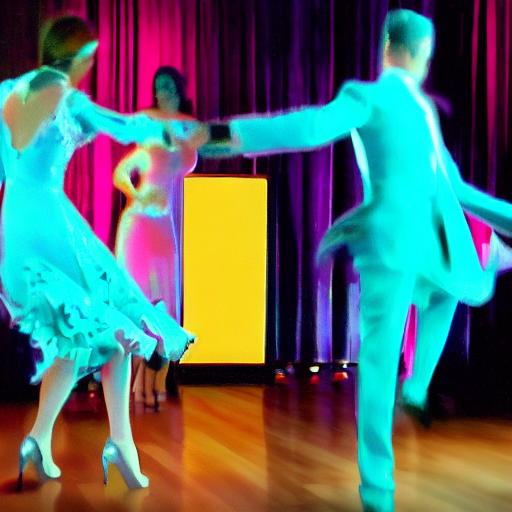

In [83]:
if batch_size > 1:
    grid = torchvision.utils.make_grid(images, nrow=2, normalize=False, range=(-1, 1))
    img = to_pil(grid)
else:
    img = to_pil(images[0])
img

In [36]:
sd.unload_model()
get_memory_status()

AttributeError: model

In [84]:
images.shape

torch.Size([1, 3, 512, 512])

In [85]:
img_encoder = CLIPImageEncoder(device=device)
get_memory_status()

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 6686 MiB
Used: 5601 MiB


In [86]:
img_encoder.load_clip_model()
get_memory_status()
# img_encoder.initialize_preprocessor()

Total: 12287 MiB
Free: 5800 MiB
Used: 6487 MiB


In [87]:
img_encoder.image_processor

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [88]:
img_encoder.input_mode = PIL.Image.Image
img_encoder.image_processor;

In [89]:
prep_from_img = img_encoder.image_processor(img).to(device)
type(img)

PIL.Image.Image

In [91]:
img_encoder.input_mode = torch.Tensor
img_encoder.image_processor

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [92]:
prep_from_tensor = img_encoder.image_processor(images)
type(images)

c:\Users\igor-\anaconda3\envs\kcg\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Tensor

In [94]:
prep_from_img.shape, prep_from_tensor.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [95]:
torch.all(prep_from_img.to(device) == prep_from_tensor)

tensor(False, device='cuda:0')

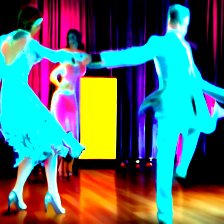

In [96]:
to_pil(prep_from_img.squeeze(0))

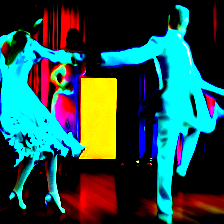

In [97]:
to_pil(prep_from_tensor.squeeze(0))

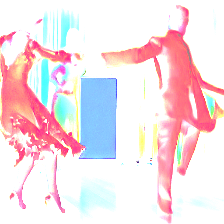

In [98]:
to_pil((prep_from_img - prep_from_tensor).squeeze(0))

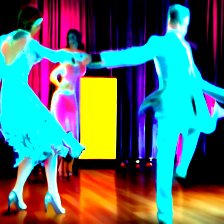

In [102]:
if batch_size > 1:
    grid = torchvision.utils.make_grid([prep_from_img, prep_from_tensor], nrow=2, normalize=False, range=(-1, 1))
    img = to_pil(grid)
else:
    img = to_pil(prep_from_img.squeeze(0))
img

In [104]:
grid = torchvision.utils.make_grid([prep_from_img.squeeze(), prep_from_tensor.squeeze()], nrow=2, normalize=False, range=(-1, 1))
img = to_pil(grid)

In [107]:
img_features_tensor = img_encoder(prep_from_tensor)
img_features_tensor.shape

torch.Size([1, 768])

In [109]:
img_features_image = img_encoder(prep_from_img)
img_features_image.shape

c:\Users\igor-\anaconda3\envs\kcg\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 768])

In [110]:
torch.norm(img_features_image - img_features_tensor)

tensor(14.6016, device='cuda:0', dtype=torch.float16)